In [1]:
%cd ../

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC


In [56]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import os
import umap
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from scipy.cluster.vq import kmeans2
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution, source_distribution
from utils import *

In [66]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 100,
'n_runs' : 1,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",
"ablation": 'None',
"cluster_balance": 'hellinger',
"verbose": 'True',

# Model parameters
'lamda' : 1,
'beta' : 0.5, # KL loss/KM loss weight
'gamma' : 1.5, # Classification loss weight
'delta' : 1, # Class Balance weight
'eta' : 0.0, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 3,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,
'other' : 'False',
'cluster_balance' : 'hellinger',
'cluster_analysis' : 'False',
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}


class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.n_runs = params['n_runs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"
        self.ablation = params['ablation']
        self.verbose = params['verbose']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.eta = params['eta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']
        self.cluster_balance = params['cluster_balance']
        self.cluster_analysis = params['cluster_analysis']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.other = params['other']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'aki', 'infant', 'wid_mortality']

In [67]:
base_suffix = ""

for key in ['n_clusters', 'alpha', 'beta', 'gamma', 'delta', 'eta']:
    print(key, args.__dict__[key])

base_suffix += args.dataset + "_"
base_suffix += str(args.n_clusters) + "_"
base_suffix += str(args.attention)

scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data
# X_train = X_train[:,:42]
# args.input_dim = 42

n_clusters 3
alpha 1
beta 0.5
gamma 1.5
delta 1
eta 0.0
cic


Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
Starting Training
Training data


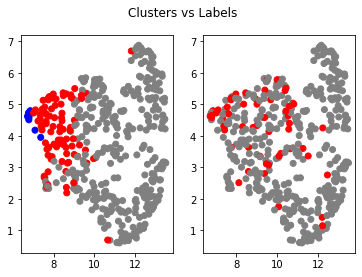


[  0/100] train_loss: 0.654 valid_loss: 0.645 valid_F1: 0.461 valid_AUC: 0.295 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.339 Complexity Term: 0.000
Epoch: 00 | Epoch KM Loss: 4.077 | Total Loss: 17.976 | Classification Loss: 3.089 | Cluster Balance Loss: 1.123
Epoch: 01 | Epoch KM Loss: 6.564 | Total Loss: 14.817 | Classification Loss: 2.342 | Cluster Balance Loss: 1.009
Training data


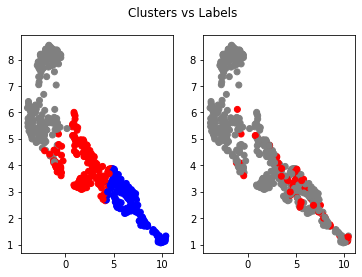


[  2/100] train_loss: 0.497 valid_loss: 0.480 valid_F1: 0.461 valid_AUC: 0.732 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.275 Complexity Term: 0.000
Epoch: 02 | Epoch KM Loss: 1.507 | Total Loss: 9.724 | Classification Loss: 1.583 | Cluster Balance Loss: 0.634
Epoch: 03 | Epoch KM Loss: 0.980 | Total Loss: 8.771 | Classification Loss: 1.192 | Cluster Balance Loss: 0.687
Training data


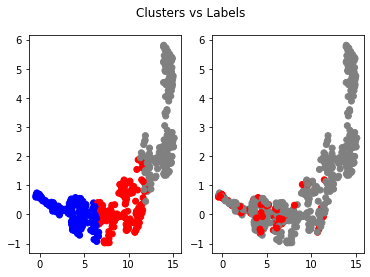


[  4/100] train_loss: 0.443 valid_loss: 0.387 valid_F1: 0.461 valid_AUC: 0.789 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.295 Complexity Term: 0.000
Epoch: 04 | Epoch KM Loss: 1.126 | Total Loss: 8.398 | Classification Loss: 1.033 | Cluster Balance Loss: 0.604
Epoch: 05 | Epoch KM Loss: 0.980 | Total Loss: 8.206 | Classification Loss: 0.934 | Cluster Balance Loss: 0.622
Training data


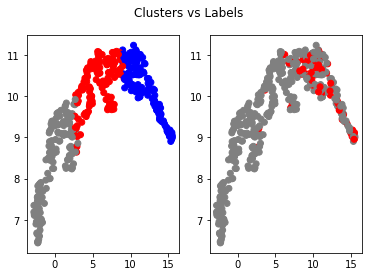


[  6/100] train_loss: 0.436 valid_loss: 0.391 valid_F1: 0.464 valid_AUC: 0.805 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.336 Complexity Term: 0.000
Epoch: 06 | Epoch KM Loss: 1.372 | Total Loss: 8.246 | Classification Loss: 0.848 | Cluster Balance Loss: 0.531
Epoch: 07 | Epoch KM Loss: 1.265 | Total Loss: 8.259 | Classification Loss: 0.845 | Cluster Balance Loss: 0.691
Training data


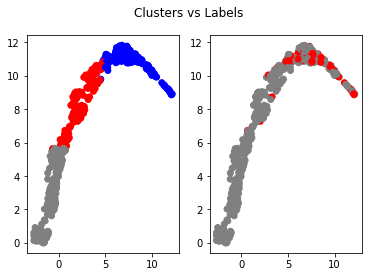


[  8/100] train_loss: 0.433 valid_loss: 0.380 valid_F1: 0.461 valid_AUC: 0.814 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.353 Complexity Term: 0.000
Epoch: 08 | Epoch KM Loss: 1.428 | Total Loss: 8.274 | Classification Loss: 0.802 | Cluster Balance Loss: 0.576
Epoch: 09 | Epoch KM Loss: 1.326 | Total Loss: 7.981 | Classification Loss: 0.758 | Cluster Balance Loss: 0.570
Training data


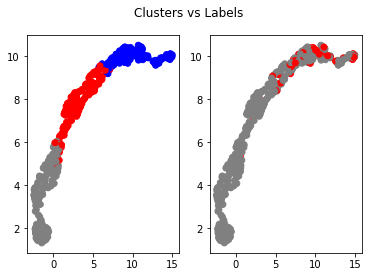


[ 10/100] train_loss: 0.433 valid_loss: 0.383 valid_F1: 0.461 valid_AUC: 0.807 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.349 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 10 | Epoch KM Loss: 1.294 | Total Loss: 8.092 | Classification Loss: 0.696 | Cluster Balance Loss: 0.588
Epoch: 11 | Epoch KM Loss: 1.402 | Total Loss: 7.997 | Classification Loss: 0.685 | Cluster Balance Loss: 0.565
Training data


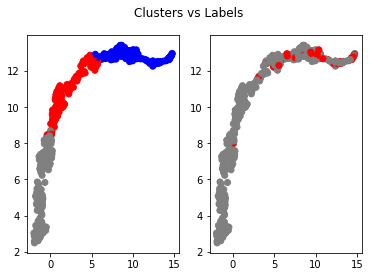


[ 12/100] train_loss: 0.425 valid_loss: 0.386 valid_F1: 0.477 valid_AUC: 0.820 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.371 Complexity Term: 0.000
Epoch: 12 | Epoch KM Loss: 1.343 | Total Loss: 7.910 | Classification Loss: 0.675 | Cluster Balance Loss: 0.525
Epoch: 13 | Epoch KM Loss: 1.335 | Total Loss: 7.854 | Classification Loss: 0.631 | Cluster Balance Loss: 0.554
Training data


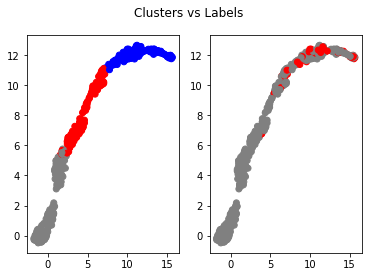


[ 14/100] train_loss: 0.424 valid_loss: 0.382 valid_F1: 0.471 valid_AUC: 0.802 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.372 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 14 | Epoch KM Loss: 1.358 | Total Loss: 7.756 | Classification Loss: 0.640 | Cluster Balance Loss: 0.511
Epoch: 15 | Epoch KM Loss: 1.332 | Total Loss: 7.811 | Classification Loss: 0.583 | Cluster Balance Loss: 0.563
Training data


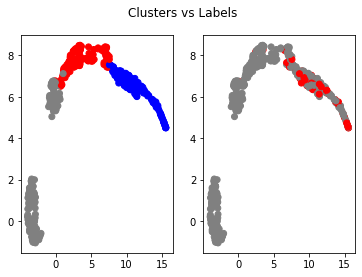


[ 16/100] train_loss: 0.421 valid_loss: 0.378 valid_F1: 0.488 valid_AUC: 0.821 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.373 Complexity Term: 0.000
Epoch: 16 | Epoch KM Loss: 1.326 | Total Loss: 7.679 | Classification Loss: 0.575 | Cluster Balance Loss: 0.505
Epoch: 17 | Epoch KM Loss: 1.304 | Total Loss: 7.794 | Classification Loss: 0.619 | Cluster Balance Loss: 0.617
Training data


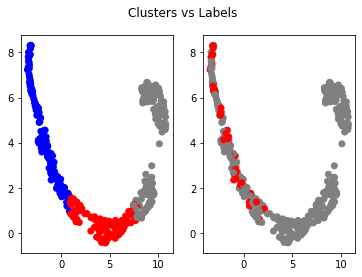


[ 18/100] train_loss: 0.420 valid_loss: 0.394 valid_F1: 0.467 valid_AUC: 0.798 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.385 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 18 | Epoch KM Loss: 1.326 | Total Loss: 7.709 | Classification Loss: 0.533 | Cluster Balance Loss: 0.587
Epoch: 19 | Epoch KM Loss: 1.325 | Total Loss: 7.534 | Classification Loss: 0.533 | Cluster Balance Loss: 0.546
Training data


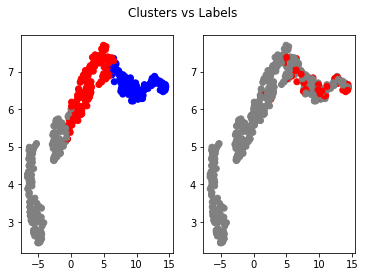


[ 20/100] train_loss: 0.416 valid_loss: 0.389 valid_F1: 0.517 valid_AUC: 0.823 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.396 Complexity Term: 0.000
Epoch: 20 | Epoch KM Loss: 1.293 | Total Loss: 7.570 | Classification Loss: 0.517 | Cluster Balance Loss: 0.574
Epoch: 21 | Epoch KM Loss: 1.276 | Total Loss: 7.412 | Classification Loss: 0.501 | Cluster Balance Loss: 0.508
Training data


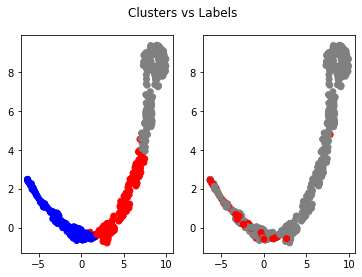


[ 22/100] train_loss: 0.414 valid_loss: 0.388 valid_F1: 0.477 valid_AUC: 0.807 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.394 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 22 | Epoch KM Loss: 1.260 | Total Loss: 7.478 | Classification Loss: 0.469 | Cluster Balance Loss: 0.503
Epoch: 23 | Epoch KM Loss: 1.298 | Total Loss: 7.379 | Classification Loss: 0.459 | Cluster Balance Loss: 0.527
Training data


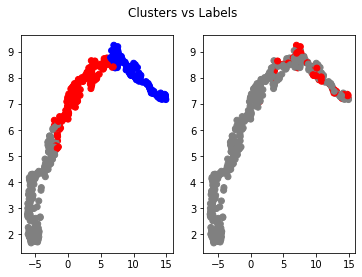


[ 24/100] train_loss: 0.413 valid_loss: 0.378 valid_F1: 0.480 valid_AUC: 0.808 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.400 Complexity Term: 0.000
EarlyStopping counter: 2 out of 7
Epoch: 24 | Epoch KM Loss: 1.290 | Total Loss: 7.442 | Classification Loss: 0.469 | Cluster Balance Loss: 0.523
Epoch: 25 | Epoch KM Loss: 1.334 | Total Loss: 7.601 | Classification Loss: 0.479 | Cluster Balance Loss: 0.677
Training data


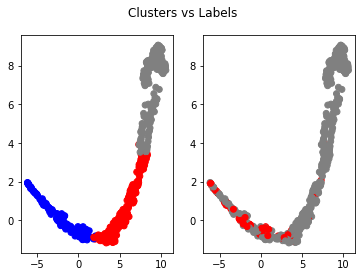


[ 26/100] train_loss: 0.411 valid_loss: 0.390 valid_F1: 0.477 valid_AUC: 0.797 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.402 Complexity Term: 0.000
EarlyStopping counter: 3 out of 7
Epoch: 26 | Epoch KM Loss: 1.265 | Total Loss: 7.428 | Classification Loss: 0.457 | Cluster Balance Loss: 0.583
Epoch: 27 | Epoch KM Loss: 1.298 | Total Loss: 7.487 | Classification Loss: 0.428 | Cluster Balance Loss: 0.539
Training data


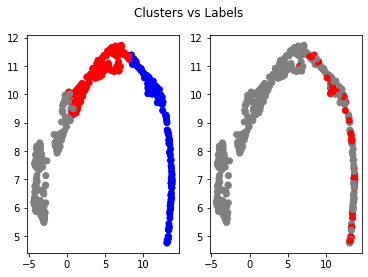


[ 28/100] train_loss: 0.414 valid_loss: 0.385 valid_F1: 0.483 valid_AUC: 0.811 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.391 Complexity Term: 0.000
EarlyStopping counter: 4 out of 7
Epoch: 28 | Epoch KM Loss: 1.227 | Total Loss: 7.383 | Classification Loss: 0.423 | Cluster Balance Loss: 0.593
Epoch: 29 | Epoch KM Loss: 1.277 | Total Loss: 7.355 | Classification Loss: 0.405 | Cluster Balance Loss: 0.604
Training data


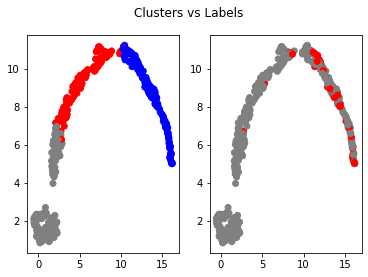


[ 30/100] train_loss: 0.413 valid_loss: 0.382 valid_F1: 0.495 valid_AUC: 0.816 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.392 Complexity Term: 0.000
EarlyStopping counter: 5 out of 7
Epoch: 30 | Epoch KM Loss: 1.224 | Total Loss: 7.263 | Classification Loss: 0.408 | Cluster Balance Loss: 0.606
Epoch: 31 | Epoch KM Loss: 1.284 | Total Loss: 7.261 | Classification Loss: 0.394 | Cluster Balance Loss: 0.567
Training data


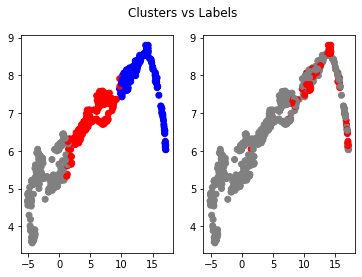


[ 32/100] train_loss: 0.409 valid_loss: 0.384 valid_F1: 0.509 valid_AUC: 0.818 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.410 Complexity Term: 0.000
EarlyStopping counter: 6 out of 7
Epoch: 32 | Epoch KM Loss: 1.284 | Total Loss: 7.221 | Classification Loss: 0.386 | Cluster Balance Loss: 0.531
Epoch: 33 | Epoch KM Loss: 1.230 | Total Loss: 7.154 | Classification Loss: 0.374 | Cluster Balance Loss: 0.514
Training data


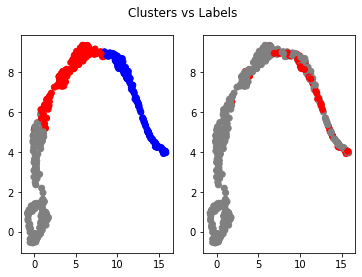


[ 34/100] train_loss: 0.408 valid_loss: 0.384 valid_F1: 0.531 valid_AUC: 0.817 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.415 Complexity Term: 0.000
EarlyStopping counter: 7 out of 7
Train Losses:  [[17.976, 3.089], [14.817, 2.342], [9.724, 1.583], [8.771, 1.192], [8.398, 1.033], [8.206, 0.934], [8.246, 0.848], [8.259, 0.845], [8.274, 0.802], [7.981, 0.758], [8.092, 0.696], [7.997, 0.685], [7.91, 0.675], [7.854, 0.631], [7.756, 0.64], [7.811, 0.583], [7.679, 0.575], [7.794, 0.619], [7.709, 0.533], [7.534, 0.533], [7.57, 0.517], [7.412, 0.501], [7.478, 0.469], [7.379, 0.459], [7.442, 0.469], [7.601, 0.479], [7.428, 0.457], [7.487, 0.428], [7.383, 0.423], [7.355, 0.405], [7.263, 0.408], [7.261, 0.394], [7.221, 0.386], [7.154, 0.374]]

####################################################################################

Training Local Networks
Loading Best model with score:  [0.5172662945983655, 0.8225574425574427]

[ 34/100] train_loss: 0.259 valid_loss: 0.346 valid_F1

In [68]:
####################################################################################
####################################################################################
####################################################################################
################################### Initialiation ##################################
####################################################################################
####################################################################################
####################################################################################

f1_scores, auc_scores, acc_scores = [], [], [] #Inattentive test results
e_f1_scores, e_auc_scores, e_acc_scores = [], [], [] #Attentive test results
sil_scores, wdfd_scores, nhfd_scores, w_nhfd_scores = [], [], [], []

# to track the training loss as the model trains
test_losses, e_test_losses, local_sum_test_losses = [], [], []
model_complexity = []

if args.ablation == "alpha":
    iter_array = alphas
    iteration_name = "Alpha"

elif args.ablation == "beta":
    iter_array = betas
    iteration_name = "Beta"

elif args.ablation == "gamma":
    iter_array = gammas
    iteration_name = "Gamma"

elif args.ablation == "delta":
    iter_array = deltas
    iteration_name = "Delta"

elif args.ablation == "k":
    iter_array = ks
    iteration_name = "K"

else:
    iter_array = range(args.n_runs)
    iteration_name = "Run"

for r in range(len(iter_array)):
    if args.verbose == 'False':
        blockPrint()

    print(iteration_name, ":", iter_array[r])

    if args.ablation == "beta":
        args.beta = iter_array[r]

    elif args.ablation == "gamma":
        args.gamma = iter_array[r]

    elif args.ablation == "delta":
        args.delta = iter_array[r]

    elif args.ablation == "k":
        args.n_clusters = iter_array[r]

    suffix = base_suffix + "_" + iteration_name + "_" + str(iter_array[r])
    model = MultiHeadIDEC(
            n_enc_1=128,
            n_enc_2=64,
            n_enc_3=32,
            n_dec_1=32,
            n_dec_2=64,
            n_dec_3=128,
            args=args).to(args.device)

    model.pretrain(train_loader, args.pretrain_path)

    optimizer = Adam(model.parameters(), lr=args.lr)

    # cluster parameter initiate
    device = args.device
    y = y_train
    x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))
    original_cluster_centers, cluster_indices = kmeans2(hidden.data.cpu().numpy(), k=args.n_clusters, minit='++')
    model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)
    criterion = nn.CrossEntropyLoss(reduction='none')


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################## Clustering Step #################################
    ####################################################################################
    ####################################################################################
    ####################################################################################


    print("Starting Training")
    model.train()
    N_EPOCHS = args.n_epochs
    es = EarlyStoppingCAC(dataset=suffix)
    train_losses, e_train_losses = [], []

    for epoch in range(N_EPOCHS):
        # beta = args.beta*(epoch*0.1)/(1+epoch*0.1)
        beta = args.beta
        # gamma = args.gamma - args.gamma*(epoch*0.1)/(1+epoch*0.1)
        gamma = args.gamma
        delta = args.delta
        eta = args.eta
        if epoch % args.log_interval == 0:
            plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)
            model.ae.eval() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].eval()

            z_train, _, q_train = model(torch.Tensor(X_train).to(args.device), output="decoded")
            q_train, q_train_p, q_train_n = q_train
            p_train = target_distribution(q_train.detach())

            # evaluate clustering performance
            cluster_indices = q_train.detach().cpu().numpy().argmax(1)
            preds = torch.zeros((len(z_train), args.n_classes))

            # Calculate Training Metrics
            nmi, acc, ari = 0, 0, 0
            train_loss = 0
            B = []

            for j in range(model.n_clusters):
                cluster_idx = np.where(cluster_indices == j)[0]
                X_cluster = z_train[cluster_idx]
                y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

                # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)
                cluster_preds = model.classifiers[j][0](X_cluster)
                train_loss += torch.sum(criterion(cluster_preds, y_cluster))

            train_loss /= len(z_train)
            # Evaluate model on Validation dataset
            qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
            q_val = qs[0]
            cluster_ids = torch.argmax(q_val, axis=1)
            preds = torch.zeros((len(z_val), args.n_classes))

            # Weighted predictions
            if args.attention == False:
                for j in range(model.n_clusters):
                    cluster_id = np.where(cluster_ids == j)[0]
                    X_cluster = z_val[cluster_id]
                    cluster_preds_val = model.classifiers[j][0](X_cluster)
                    preds[cluster_id,:] = cluster_preds_val

            else:
                for j in range(model.n_clusters):
                    X_cluster = z_val
                    cluster_preds = model.classifiers[j][0](X_cluster)
                    for c in range(args.n_classes):
                        preds[:,c] += q_val[:,j]*cluster_preds[:,c]

            # print("qval", torch.sum(q_val, axis=0))
            # print("Cluster Counts", np.bincount(cluster_ids))
            # print("KL div", torch.kl_div(torch.sum(q_val, axis=0),\
            #                         torch.ones(args.n_clusters)/args.n_clusters))

            # Classification Matrics
            val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1), average="macro")
            val_auc = multi_class_auc(y_val, preds.detach().numpy(), args.n_classes)

            # Clustering Metrics
            val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
            val_feature_diff, val_WDFD = 0, 0
            # val_feature_diff = calculate_nhfd(X_val, cluster_ids)
            # val_WDFD = calculate_WDFD(X_val, cluster_ids)
            complexity_term = 0
            # complexity_term  = calculate_bound(model, B, len(z_train))

            val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))

            # # record validation loss
            # valid_losses.append(loss.item())

            # # calculate average loss over an epoch
            # valid_loss = np.average(valid_losses)
            # avg_valid_losses.append(valid_loss)

            epoch_len = len(str(N_EPOCHS))

            print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.3f} ' +
                         f'valid_loss: {val_loss:.3f} '  +
                         f'valid_F1: {val_f1:.3f} '  +
                         f'valid_AUC: {val_auc:.3f} ' + 
                         f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                         f'valid_WDFD: {val_WDFD:.3f} ' + 
                         f'valid_Silhouette: {val_sil:.3f} ' + 
                         f'Complexity Term: {complexity_term:.3f}')

            print(print_msg)

            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            es([val_f1, val_auc], model)
            if es.early_stop == True:
                break

        # Normal Training
        epoch_loss = 0
        epoch_balance_loss = 0
        epoch_class_loss = 0
        epoch_km_loss = 0
        
        model.ae.train() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].train()

        for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
            total_loss = 0
            x_batch = x_batch.to(device)
            idx = idx.to(device)

            X_latents, x_bar, q_batch = model(x_batch)
            q_batch = q_batch[0]
            reconstr_loss = F.mse_loss(x_bar, x_batch)

            classifier_labels = np.zeros(len(idx))
            if args.other == "True":
                sub_epochs = 1
            else:
                sub_epochs = min(10, 1 + int(epoch/5))

            if args.attention == "False" or args.other == "True":
                classifier_labels = np.argmax(q_batch.detach().cpu().numpy(), axis=1)

            for _ in range(sub_epochs):
                # Choose classifier for a point probabilistically
                if args.attention == "True":
                    for j in range(len(idx)):
                        classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())

                for k in range(args.n_clusters):
                    idx_cluster = np.where(classifier_labels == k)[0]
                    X_cluster = X_latents[idx_cluster]
                    y_cluster = y_batch[idx_cluster]

                    classifier_k, optimizer_k = model.classifiers[k]
                    # Do not backprop the error to encoder
                    y_pred_cluster = classifier_k(X_cluster.detach())
                    cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                    optimizer_k.zero_grad()
                    cluster_loss.backward(retain_graph=True)
                    optimizer_k.step()

            # Back propagate the error corresponding to last clustering
            class_loss = torch.tensor(0.).to(args.device)
            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                y_pred_cluster = classifier_k(X_cluster)
                class_loss += torch.sum(q_batch[idx_cluster,k]*criterion(y_pred_cluster, y_cluster))

            class_loss /= len(X_latents)
            delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
            cluster_id = torch.argmax(q_batch, 1)
            # print(np.bincount(cluster_id.cpu().numpy()))

            km_loss             = 0
            dcn_loss            = 0
            class_sep_loss      = 0

            # k-Means loss
            if args.eta > 0 and args.other == "True":
                for j in range(args.n_clusters):
                    pts_index = np.where(cluster_id == j)[0]
                    cluster_pts = X_latents[pts_index]
                    delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))
                    dcn_loss += torch.linalg.norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))

            q_batch = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
            P = torch.sum(torch.nn.Softmax(dim=1)(10*q_batch), axis=0)
            P = P/P.sum()
            Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

            if args.cluster_balance == "kl":
                cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
            else:
                cluster_balance_loss = torch.linalg.norm(torch.sqrt(P) - torch.sqrt(Q))

            km_loss = F.kl_div(q_batch.log(), p_train[idx], reduction='batchmean')

            loss = reconstr_loss
            if args.beta != 0:
                loss += beta*km_loss
            if args.gamma != 0:
                loss += gamma*class_loss
            if args.delta != 0:
                loss += delta*cluster_balance_loss
            if args.eta != 0:
                loss += eta*dcn_loss

            epoch_loss += loss
            epoch_class_loss += class_loss
            epoch_balance_loss += cluster_balance_loss
            epoch_km_loss += km_loss
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            # Update the positive and negative centroids
            if args.eta > 0 and args.other == True:
                for j in range(args.n_clusters):
                    pts_index = np.where(cluster_id == j)[0]
                    N  = len(pts_index)
                    model.cluster_layer.data[j:] -= (1/(100+N))*delta_mu[j:]

        print('Epoch: {:02d} | Epoch KM Loss: {:.3f} | Total Loss: {:.3f} | Classification Loss: {:.3f} | Cluster Balance Loss: {:.3f}'.format(
                    epoch, epoch_km_loss, epoch_loss, epoch_class_loss, loss))
        train_losses.append([np.round(epoch_loss.item(),3), np.round(epoch_class_loss.item(),3)])

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Local Training #################################
    ####################################################################################
    ####################################################################################
    ####################################################################################
    if args.other == "False":
        print('Train Losses: ', train_losses)
        print("\n####################################################################################\n")
        print("Training Local Networks")
        model = es.load_checkpoint(model)

        es = EarlyStoppingCAC(dataset=suffix)

        qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
        q_train = qs[0]
        cluster_id_train = torch.argmax(q_train, axis=1)

        # X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
        X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

        train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
            batch_size=1024, shuffle=False)

        B = []

        # plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
        #      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

        # Post clustering training
        for e in range(N_EPOCHS):
            epoch_loss = 0
            epoch_acc = 0
            epoch_f1 = 0
            acc = 0

            # model.ae.train() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].train()

            # Full training of local networks
            for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
                # torch.autograd.set_detect_anomaly(True)

                classifier_labels = np.zeros(len(X_latents))
                # Choose classifier for a point probabilistically
                if args.attention == True:
                    for j in range(len(X_latents)):
                        classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
                else:
                    classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

                for k in range(args.n_clusters):
                    idx_cluster = np.where(classifier_labels == k)[0]
                    X_cluster = X_latents[idx_cluster]
                    y_cluster = y_batch[idx_cluster]

                    classifier_k, optimizer_k = model.classifiers[k]
                    # Do not backprop the error to encoder
                    y_pred_cluster = classifier_k(X_cluster.detach())
                    cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                    optimizer_k.zero_grad()
                    cluster_loss.backward(retain_graph=True)
                    optimizer_k.step()
            
            # model.ae.eval() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].eval()

            train_preds = torch.zeros((len(z_train), args.n_classes))
            train_loss = 0

            # Weighted predictions
            q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
            q_train = q_train[0]
            cluster_ids_train = torch.argmax(q_train, axis=1)
            
            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids_train == j)[0]
                X_cluster = z_train
                y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

                # Ensemble train loss
                cluster_preds = model.classifiers[j][0](X_cluster)
                for c in range(args.n_classes):
                    train_preds[:,c] += q_train[:,j]*cluster_preds[:,c]

                X_cluster = z_train[cluster_id]
                cluster_preds = model.classifiers[j][0](X_cluster)
                train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
                # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


            train_loss /= len(z_train)
            e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

            # Evaluate model on Validation set
            qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
            q_val = qs[0]
            cluster_ids_val = torch.argmax(q_val, axis=1)
            preds = torch.zeros((len(z_val), args.n_classes))

            # Weighted predictions
            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids_val == j)[0]
                X_cluster = z_val
                cluster_preds = model.classifiers[j][0](X_cluster)
                for c in range(args.n_classes):
                    preds[:,c] += q_val[:,j]*cluster_preds[:,c]

            val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1), average="macro")
            val_auc = multi_class_auc(y_val, preds.detach().numpy(), args.n_classes)
            val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

            val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
            # record validation loss
            # valid_losses.append(loss.item())

            # calculate average loss over an epoch
            # valid_loss = np.average(valid_losses)
            # avg_valid_losses.append(valid_loss)
            
            epoch_len = len(str(N_EPOCHS))
            
            print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.3f} ' +
                         f'valid_loss: {val_loss:.3f} '  +
                         f'valid_F1: {val_f1:.3f} '  +
                         f'valid_AUC: {val_auc:.3f} ' +
                         f'valid_Sil: {val_sil:.3f}')
            
            print(print_msg)
            
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            es([val_f1, val_auc], model)
            if es.early_stop == True:
                # train_losses.append(train_loss.item())
                # e_train_losses.append(e_train_loss.item())
                sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
                nhfd_scores.append(calculate_nhfd(X_train,  cluster_ids_train))
                wdfd_scores.append(calculate_WDFD(X_train,  cluster_ids_train))
                # mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
                # model_complexity.append(calculate_bound(model, B, len(z_train)))
                break


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Testing Perf. ##################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

    # Load best model trained from local training phase
    model = es.load_checkpoint(model)

    # # Evaluate model on Test dataset
    qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
    q_test = qs[0]
    cluster_ids = torch.argmax(q_test, axis=1)
    # cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
    test_preds_e = torch.zeros((len(z_test), args.n_classes))

    test_loss = 0
    e_test_loss = 0
    local_sum_loss = 0

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_test
        cluster_test_preds = model.classifiers[j][0](X_cluster)
        for c in range(args.n_classes):
            test_preds_e[:,c] += q_test[:,j]*cluster_test_preds[:,c]
    
    e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
    e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1), average="macro")
    e_test_auc = multi_class_auc(y_test, test_preds_e.detach().numpy(), args.n_classes)
    e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
    e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

    test_preds = torch.zeros((len(z_test), args.n_classes))


    # Hard local predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_test[cluster_id]
        y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
        cluster_test_preds = model.classifiers[j][0](X_cluster)
        test_preds[cluster_id,:] = cluster_test_preds
        local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))
    
    test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1), average="macro")
    test_auc = multi_class_auc(y_test, test_preds.detach().numpy(), args.n_classes)
    test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
    test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
    local_sum_loss /= len(X_test)

    test_losses.append(test_loss.item())
    e_test_losses.append(e_test_loss.item())
    local_sum_test_losses.append(local_sum_loss.item())

    # enablePrint()
    print("Run #{}".format(r))
    print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

    print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
          ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

    print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
        ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

    print("\n")

    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    acc_scores.append(test_acc)

    e_f1_scores.append(e_test_f1)
    e_auc_scores.append(e_test_auc)
    e_acc_scores.append(e_test_acc)

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Feature Imp. ###################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    if args.cluster_analysis == "True":
        regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
        qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
        q_train = qs[0]
        cluster_ids = torch.argmax(q_train, axis=1)
        train_preds_e = torch.zeros((len(z_train), args.n_classes))
        feature_importances = np.zeros((args.n_clusters, args.input_dim))

        # Weighted predictions
        for j in range(model.n_clusters):
            X_cluster = z_train
            cluster_preds = model.classifiers[j][0](X_cluster)
            # print(q_test, cluster_preds[:,0])
            for c in range(args.n_classes):
                train_preds_e[:,c] += q_train[:,j]*cluster_preds[:,c]

        for j in range(model.n_clusters):
            cluster_id = torch.where(cluster_ids == j)[0]
            X_cluster = X_train[cluster_id]
            if args.attention == True:
                y_cluster = train_preds_e[cluster_id][:,1]
            else:
                y_cluster = train_preds[cluster_id][:,1]

            # Some test data might not belong to any cluster
            if len(cluster_id) > 0:
                regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
                best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
                feature_importances[j,:] = regs[j].feature_importances_
                # print("Cluster # ", j, "sized: ", len(cluster_id))
                # print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
                # print("=========================\n")

        feature_diff = 0
        cntr = 0
        for i in range(args.n_clusters):
            for j in range(args.n_clusters):
                if i > j:
                    ci = torch.where(cluster_ids == i)[0]
                    cj = torch.where(cluster_ids == j)[0]
                    Xi = X_train[ci]
                    Xj = X_train[cj]
                    feature_diff += 100*sum(feature_importances[i]*feature_importances[j]*(ttest_ind(Xi, Xj, axis=0)[1] < 0.05))/args.input_dim
                    # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                    cntr += 1

        # print("Average Feature Difference: ", feature_diff/cntr)
        if cntr == 0:
            w_nhfd_scores.append(0)
        else:
            w_nhfd_scores.append(feature_diff/cntr)


In [9]:
def plot_hist(x, y, bins=10):
    minn = min(np.min(x), np.min(y))
    maxx = max(np.max(x), np.max(y))
    range_x = np.max(x) - np.min(x)
    range_y = np.max(y) - np.min(y)
    gap = min(range_x, range_y)/bins

    if gap < 1e-5:
        return 0

    h1, r1 = np.histogram(x, np.arange(minn-gap, maxx+gap, gap))
    h2, r2 = np.histogram(y, np.arange(minn-gap, maxx+gap, gap))
    k1 = [(r1[j]+r1[j-1])/2 for j in range(1, len(r1))]
    k2 = [(r2[j]+r2[j-1])/2 for j in range(1, len(r2))]
    # print(h1, h2, k1)

    fig, axes = plt.subplots(1, 2)

    axes[0].bar(k1, h1, label='X1', alpha=.5)
    axes[1].bar(k2, h2, label='X2', alpha=.5)
    # axes[0].hist(h1, bins=r1, label='X1', alpha=.5)
    # axes[1].hist(h2, bins=r2, label='X2', alpha=.5)
    plt.show()

## MIFD Cluster Analysis



MIFD Analysis of Clusters:  1,0
|C1| =  1087 , |C2| =  962
MI = 1.325 ; Feature: TroponinT_first - C1 Mean: 1.093 , C2 Mean: 1.167


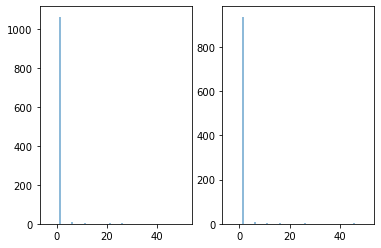

MI = 1.283 ; Feature: AST_last - C1 Mean: 236.805 , C2 Mean: 241.488


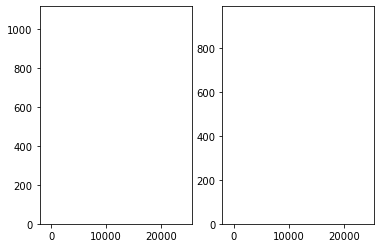

MI = 1.106 ; Feature: AST_first - C1 Mean: 249.817 , C2 Mean: 249.432


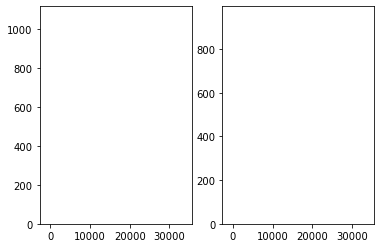

MI = 0.99 ; Feature: CCU - C1 Mean: 0.146 , C2 Mean: 0.15


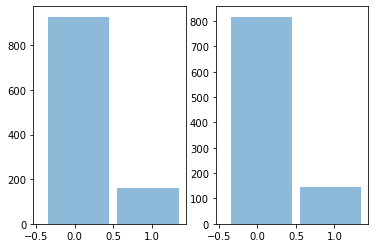

MI = 0.921 ; Feature: Bilirubin_first - C1 Mean: 1.835 , C2 Mean: 1.892


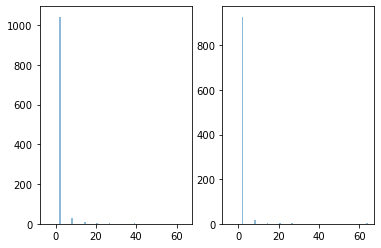

MI = 0.919 ; Feature: ALT_first - C1 Mean: 172.135 , C2 Mean: 165.383


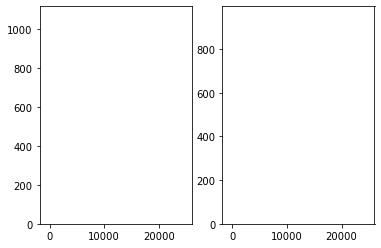

MI = 0.917 ; Feature: TroponinI_first - C1 Mean: 7.374 , C2 Mean: 7.432


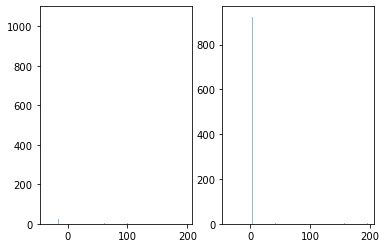

MI = 0.889 ; Feature: TroponinI_last - C1 Mean: 6.294 , C2 Mean: 6.546


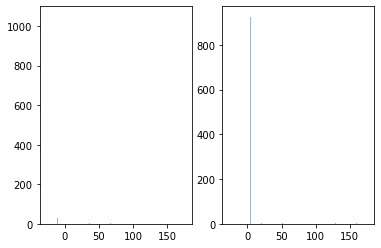

MI = 0.854 ; Feature: TroponinT_last - C1 Mean: 1.015 , C2 Mean: 1.075


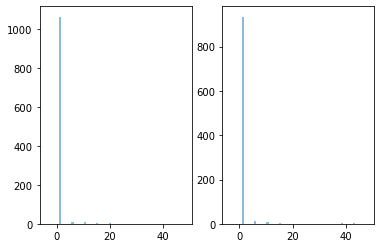

MI = 0.783 ; Feature: CSRU - C1 Mean: 0.228 , C2 Mean: 0.221


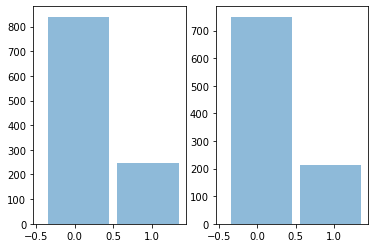



MIFD Analysis of Clusters:  2,0
|C1| =  951 , |C2| =  962
MI = 1.443 ; Feature: ALT_last - C1 Mean: 175.977 , C2 Mean: 206.993


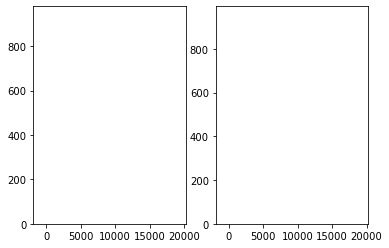

MI = 1.138 ; Feature: ALT_first - C1 Mean: 165.393 , C2 Mean: 165.383


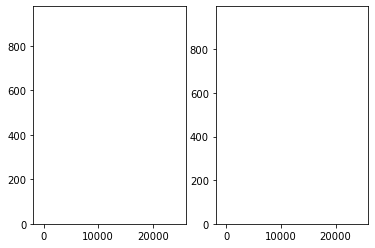

MI = 1.053 ; Feature: AST_last - C1 Mean: 201.369 , C2 Mean: 241.488


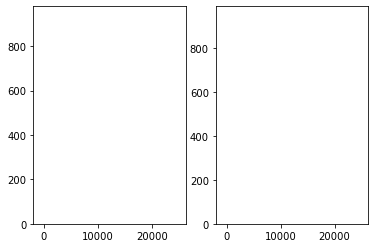

MI = 1.026 ; Feature: TroponinT_first - C1 Mean: 1.149 , C2 Mean: 1.167


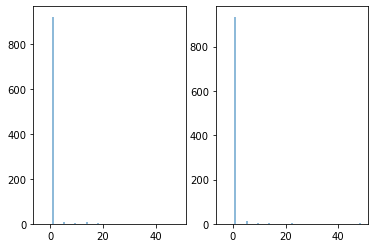

MI = 0.993 ; Feature: ALP_last - C1 Mean: 105.391 , C2 Mean: 106.202


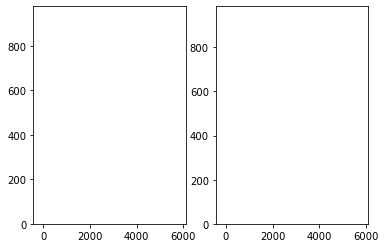

MI = 0.982 ; Feature: CCU - C1 Mean: 0.15 , C2 Mean: 0.15


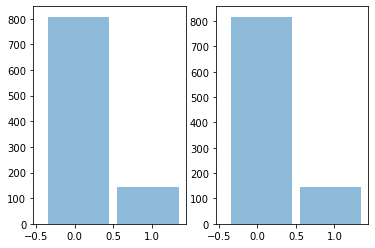

MI = 0.956 ; Feature: TroponinT_last - C1 Mean: 1.073 , C2 Mean: 1.075


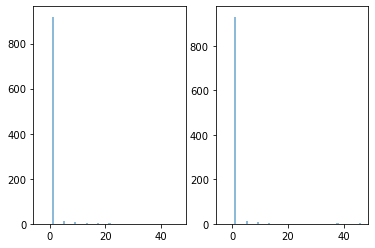

MI = 0.807 ; Feature: CSRU - C1 Mean: 0.204 , C2 Mean: 0.221


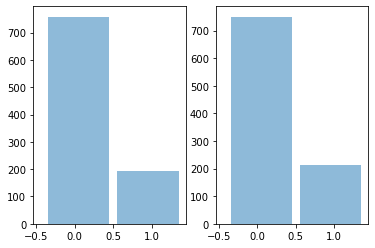

MI = 0.805 ; Feature: TroponinI_last - C1 Mean: 6.779 , C2 Mean: 6.546


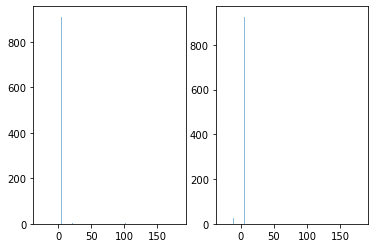

MI = 0.786 ; Feature: AST_first - C1 Mean: 235.478 , C2 Mean: 249.432


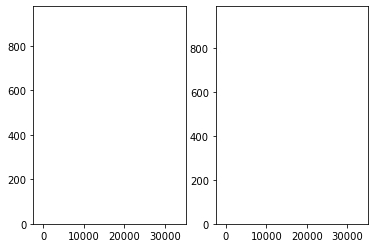



MIFD Analysis of Clusters:  2,1
|C1| =  951 , |C2| =  1087
MI = 13.302 ; Feature: Gender - C1 Mean: 0.565 , C2 Mean: 0.562


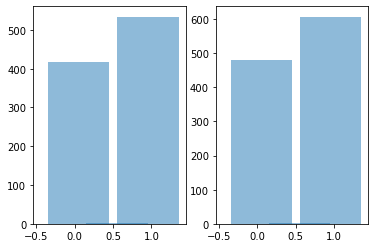

MI = 1.303 ; Feature: AST_last - C1 Mean: 201.369 , C2 Mean: 236.805


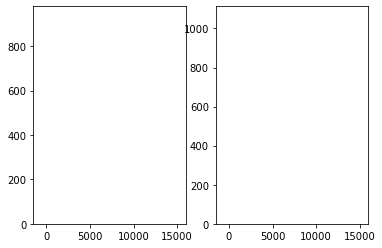

MI = 1.293 ; Feature: ALT_first - C1 Mean: 165.393 , C2 Mean: 172.135


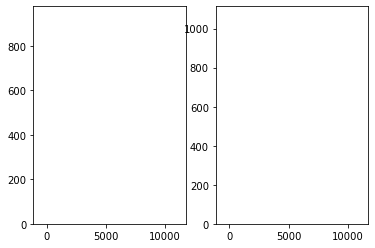

MI = 1.159 ; Feature: AST_first - C1 Mean: 235.478 , C2 Mean: 249.817


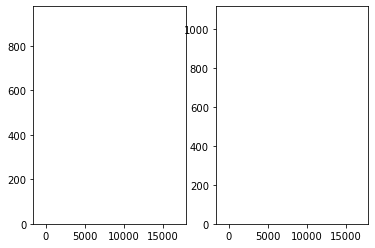

MI = 1.123 ; Feature: TroponinT_first - C1 Mean: 1.149 , C2 Mean: 1.093


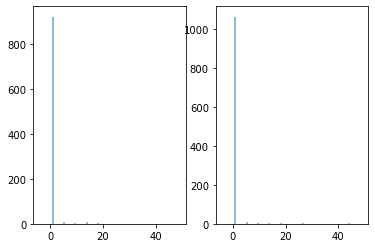

MI = 1.033 ; Feature: TroponinT_last - C1 Mean: 1.073 , C2 Mean: 1.015


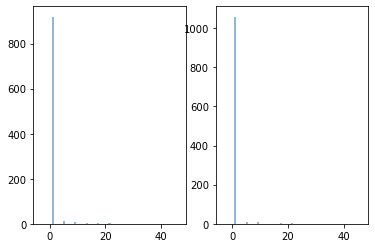

MI = 0.991 ; Feature: CCU - C1 Mean: 0.15 , C2 Mean: 0.146


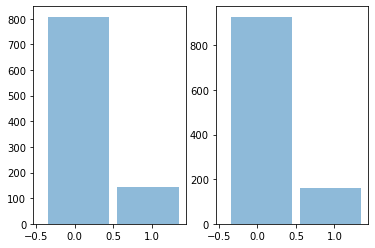

MI = 0.914 ; Feature: TroponinI_last - C1 Mean: 6.779 , C2 Mean: 6.294


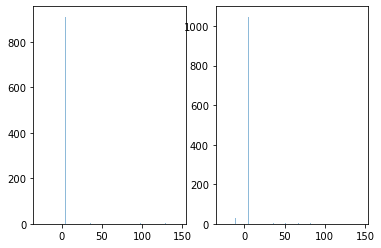

MI = 0.909 ; Feature: Bilirubin_last - C1 Mean: 1.711 , C2 Mean: 1.846


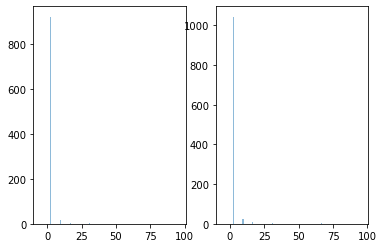

MI = 0.896 ; Feature: TroponinI_first - C1 Mean: 7.161 , C2 Mean: 7.374


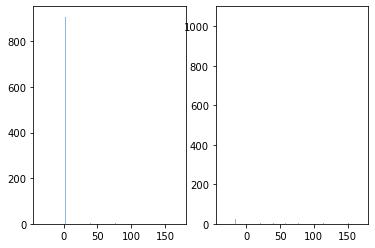

In [12]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = scale.inverse_transform(X_train)

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = calc_MI(Xi[:,c], Xj[:,c], 0)
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("MIFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C1| = ", len(ci), ", |C2| = ", len(cj))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## NHFD



1,0
{'HCT_first': 0.862, 'PaO2_last': 0.589, 'PaO2_first': 0.568, 'Height': 0.515, 'Platelets_last': 0.497, 'Platelets_first': 0.31, 'HCT_last': 0.272, 'Albumin_first': 0.237, 'Weight_first': 0.226, 'MAP_lowest': 0.17}
0.862 HCT_first - C1: -0.050447399145810826 , C2: 0.06873444658331164


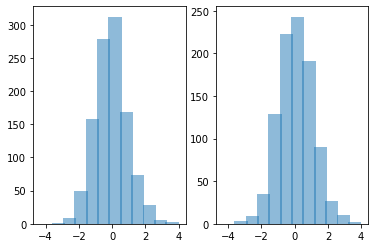

0.589 PaO2_last - C1: 0.06372110178936966 , C2: -0.03720834822088376


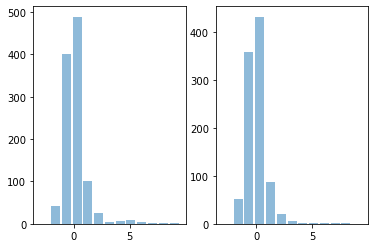

0.568 PaO2_first - C1: 0.056833715789688655 , C2: -0.04040495253218881


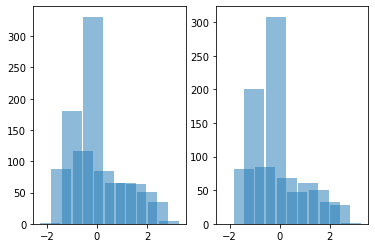

0.515 Height - C1: -0.015355625226319052 , C2: 0.0030613698779301886


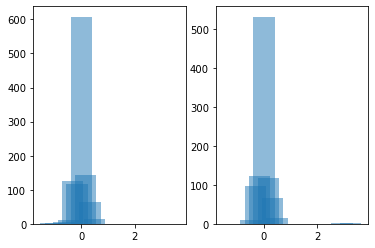

0.497 Platelets_last - C1: -0.06337329476866031 , C2: 0.025577353177513928


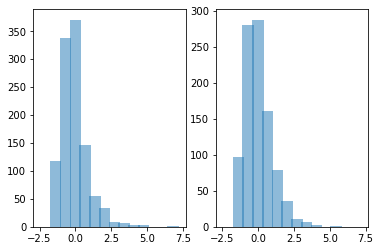

0.31 Platelets_first - C1: -0.06394859342898247 , C2: 0.014896449897901757


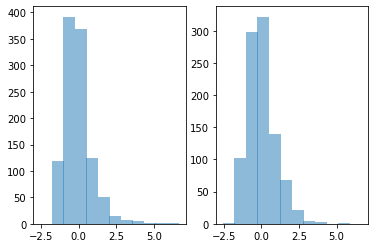

0.272 HCT_last - C1: -0.025264188649186222 , C2: 0.05621444291838809


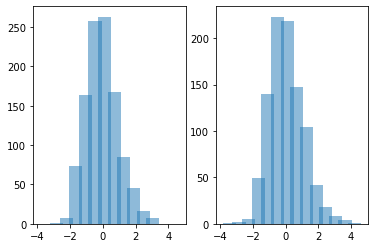

0.237 Albumin_first - C1: -0.02295534370795537 , C2: 0.05634607083350796


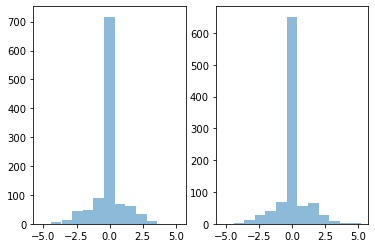

0.226 Weight_first - C1: -0.020864396319451223 , C2: 0.06140158709543554


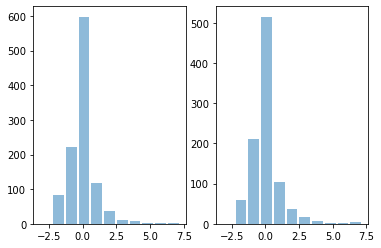

0.17 MAP_lowest - C1: -0.054070593923115785 , C2: 0.029906968755475976


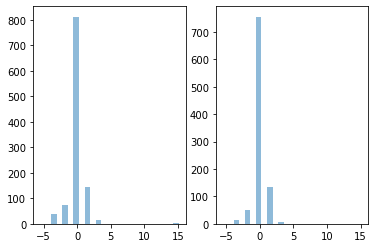



2,0
{'DiasABP_highest': 0.55, 'Weight_last': 0.417, 'DiasABP_first': 0.358, 'NISysABP_highest': 0.298, 'Weight_first': 0.283, 'SysABP_first': 0.213, 'MechVentStartTime': 0.172, 'Creatinine_last': 0.067, 'NIDiasABP_lowest': 0.06, 'MechVentLast8Hour': 0.056}
0.55 DiasABP_highest - C1: 0.09278530121984743 , C2: -0.011539720823904214


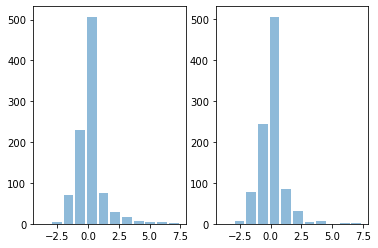

0.417 Weight_last - C1: -0.040478845802222614 , C2: 0.05772731555240803


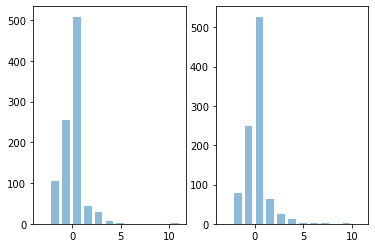

0.358 DiasABP_first - C1: 0.05140115245521294 , C2: -0.03907057466424358


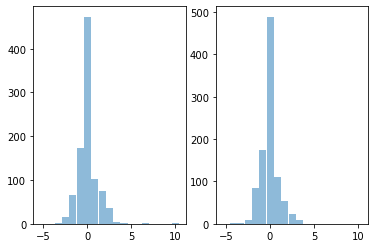

0.298 NISysABP_highest - C1: 0.056333289552005755 , C2: -0.031010255066600455


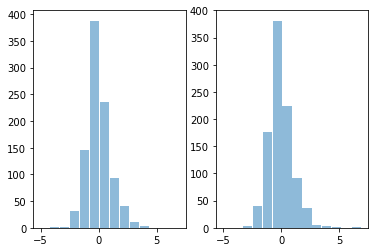

0.283 Weight_first - C1: -0.029052177348910264 , C2: 0.06140158709543554


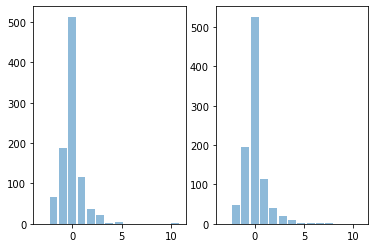

0.213 SysABP_first - C1: 0.03495484017929495 , C2: -0.042608569406852266


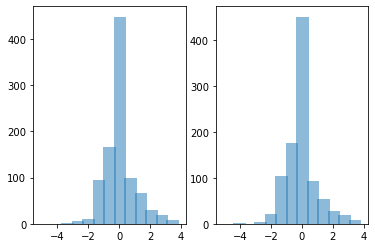

0.172 MechVentStartTime - C1: 0.019393330620936688 , C2: -0.05458397228908347


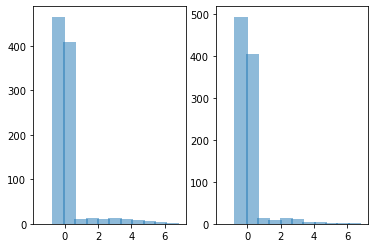

0.067 Creatinine_last - C1: -0.05343383962016795 , C2: 0.01329450733973774


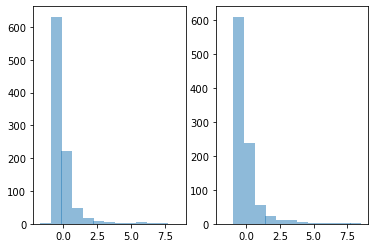

0.06 NIDiasABP_lowest - C1: -0.04534802622279417 , C2: 0.02331509543693583


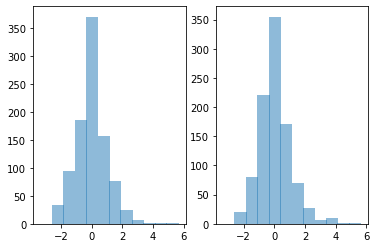

0.056 MechVentLast8Hour - C1: 0.04157392043237886 , C2: -0.025161582401570556


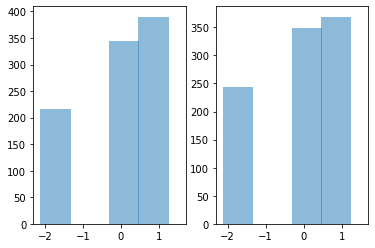



2,1
{'PaO2_last': 0.622, 'Na_first': 0.446, 'NIDiasABP_highest': 0.414, 'SaO2_highest': 0.317, 'BUN_last': 0.287, 'Mg_first': 0.211, 'MAP_first': 0.21, 'FiO2_first': 0.196, 'DiasABP_highest': 0.186, 'MAP_lowest': 0.185}
0.622 PaO2_last - C1: -0.03830649537963329 , C2: 0.06372110178936966


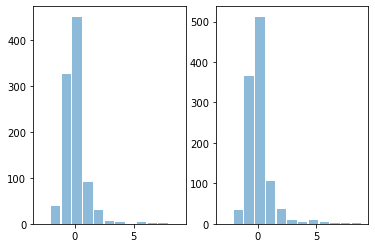

0.446 Na_first - C1: 0.06995983810647172 , C2: -0.025754840373952752


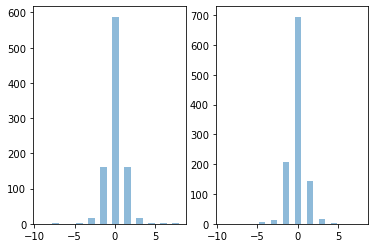

0.414 NIDiasABP_highest - C1: 0.0444350889198036 , C2: -0.04205585809315439


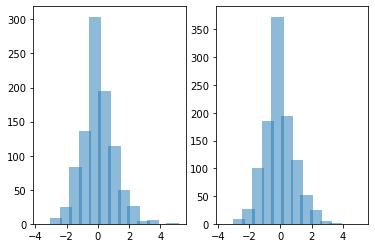

0.317 SaO2_highest - C1: -0.03768536767720793 , C2: 0.04438545670269562


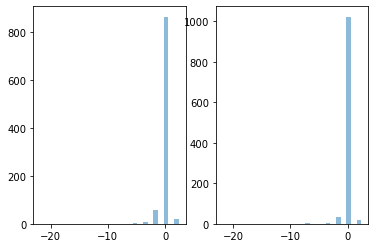

0.287 BUN_last - C1: -0.0535824220550693 , C2: 0.028761850320616508


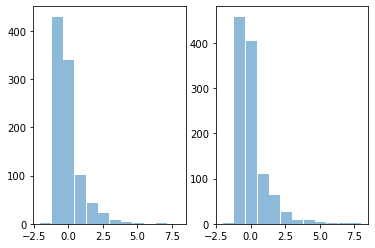

0.211 Mg_first - C1: -0.01712188070448768 , C2: 0.09388521303369923


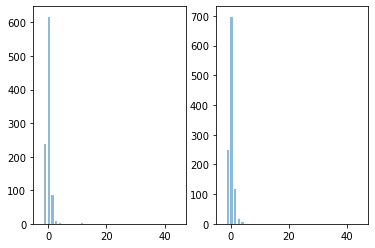

0.21 MAP_first - C1: 0.06091179521256455 , C2: -0.021514509548223384


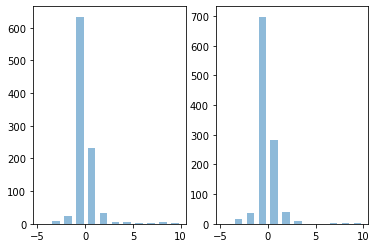

0.196 FiO2_first - C1: -0.043108267145460795 , C2: 0.03563746404494349


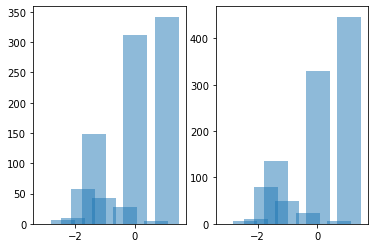

0.186 DiasABP_highest - C1: 0.09278530121984743 , C2: 0.009907847866328666


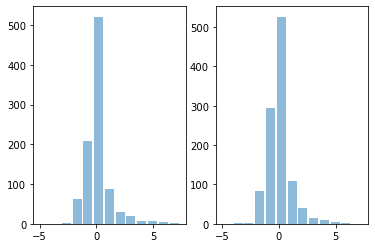

0.185 MAP_lowest - C1: 0.03511360285244483 , C2: -0.054070593923115785


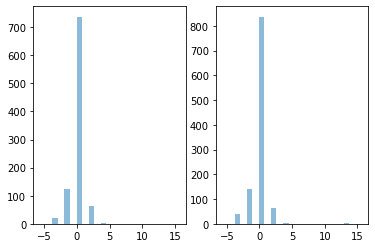

In [13]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = X_train
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi, Xj, axis=0, equal_var=True))[1]
            for c in range(n_columns):
                mi_scores[joint_col_name][c] = np.round(np.exp(-p_vals[c]/0.05), 3)
                # print(column_names[c], ":", c_entropy)
            cntr += 1
            print("\n========\n")
            print(joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            print({column_names[k]: v for k, v in sorted_dict})
            for k, v in sorted_dict:
                print(v, column_names[k], "- C1:", np.mean(scaled_X_train[ci][:,k]), ", C2:", np.mean(scaled_X_train[cj][:,k]))
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## WDFD

In [14]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = scale.inverse_transform(X_train)

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = wd(Xi[:,c], Xj[:,c])
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("WDFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C{}| = {}, |C{}| = {}".format(i, len(ci), j, len(cj)))
            print("|C{}| = {:.3f}, |C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci), j, sum(y_train[cj])/len(cj)))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                # plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])



WDFD Analysis of Clusters:  1,0
|C1| = 1087, |C0| = 962
|C1| = 0.156, |C0| = 0.149
MI = 0.148 ; Feature: MAP_lowest - C1 Mean: 57.543 , C2 Mean: 58.935
MI = 0.133 ; Feature: HCT_first - C1 Mean: 31.626 , C2 Mean: 32.344
MI = 0.12 ; Feature: PaCO2_first - C1 Mean: 41.106 , C2 Mean: 41.389
MI = 0.119 ; Feature: Platelets_first - C1 Mean: 208.662 , C2 Mean: 217.621
MI = 0.113 ; Feature: Platelets_last - C1 Mean: 186.015 , C2 Mean: 195.177
MI = 0.103 ; Feature: PaO2_last - C1 Mean: 120.625 , C2 Mean: 115.547
MI = 0.1 ; Feature: PaO2_first - C1 Mean: 211.138 , C2 Mean: 199.101
MI = 0.095 ; Feature: Mg_first - C1 Mean: 1.984 , C2 Mean: 1.943
MI = 0.091 ; Feature: ALT_last - C1 Mean: 170.344 , C2 Mean: 206.993
MI = 0.09 ; Feature: HCT_last - C1 Mean: 30.744 , C2 Mean: 31.124


WDFD Analysis of Clusters:  2,0
|C2| = 951, |C0| = 962
|C2| = 0.129, |C0| = 0.149
MI = 0.107 ; Feature: DiasABP_highest - C1 Mean: 85.21 , C2 Mean: 83.389
MI = 0.106 ; Feature: HCO3_last - C1 Mean: 24.203 , C2 Mean: 2

In [53]:
def NHFD_Single_Cluster_Analysis(X_train, cluster_ids, column_names):
    print("\nCluster Wise discriminative features (NHFD)")
    cluster_entrpy = 0
    cntr = 0
    n_columns = X_train.shape[1]
    n_clusters = len(torch.unique(cluster_ids))
    input_dim = X_train.shape[1]
    mi_scores = {}
    for i in range(n_clusters):
        mi_scores[i] = {}
        ci = torch.where(cluster_ids == i)[0]
        for c in range(n_columns):
            Xi_c = X_train[ci][:,c]
            Zc = []
            # Collect values from other clusters
            for j in range(n_clusters):
                if i != j:
                    cj = torch.where(cluster_ids == j)[0]                    
                    Xj_c = X_train[cj][:,c]
                    Zc = np.concatenate([Zc, Xj_c])

            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi_c, Zc, axis=0, equal_var=True))[1]
#             p_vals = np.nan_to_num(wd(Xi_c, Zc))
            # p_vals = np.nan_to_num(calc_MI(Xi_c, Zc,0))
            mi_scores[i][c] = np.round(np.exp(-p_vals/0.05), 3)
#             mi_scores[i][c] = p_vals

        print("\n========\n")
        print("|C{}| = {}".format(i, len(ci)))
        print("|C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci)))

        sorted_dict = sorted(mi_scores[i].items(), key=lambda item: -item[1])
        for feature, pval in sorted_dict:
            f = column_names[feature]
            print(f, "\t", pval, end='\t')
            for cluster_id in range(n_clusters):
                    c_cluster_id = torch.where(cluster_ids == cluster_id)[0]
                    X_cluster_f = X_train[c_cluster_id][:,feature]
                    print("({:.3f}, {:.3f})".format(np.round(np.mean(X_cluster_f),3), np.round(np.std(X_cluster_f),3)), end='\t')
            print('')


In [55]:
NHFD_Single_Cluster_Analysis(scaled_X_train, cluster_ids, column_names)


Cluster Wise discriminative features (NHFD)


|C0| = 962
|C0| = 0.149
HCT_first 	 0.542	(32.344, 6.275)	(31.626, 5.838)	(32.072, 5.954)	
Weight_first 	 0.498	(85.914, 26.388)	(83.901, 24.598)	(83.701, 25.631)	
Weight_last 	 0.439	(86.428, 26.479)	(84.715, 24.538)	(84.062, 24.709)	
Albumin_first 	 0.176	(3.026, 0.645)	(2.974, 0.656)	(2.992, 0.645)	
PaO2_first 	 0.162	(199.101, 121.153)	(211.138, 126.111)	(202.942, 124.760)	
MechVentStartTime 	 0.16	(258.748, 426.183)	(286.415, 506.260)	(294.567, 489.094)	
Platelets_last 	 0.134	(195.177, 97.197)	(186.015, 98.750)	(191.954, 102.257)	
NIDiasABP_lowest 	 0.111	(41.113, 13.100)	(40.362, 12.829)	(40.234, 12.942)	
SysABP_first 	 0.068	(122.728, 26.435)	(123.824, 28.002)	(124.856, 26.178)	
Albumin_last 	 0.062	(2.982, 0.632)	(2.936, 0.653)	(2.954, 0.641)	
DiasABP_highest 	 0.06	(83.389, 16.780)	(83.763, 18.021)	(85.210, 19.758)	
HCO3_last 	 0.049	(24.468, 4.470)	(24.248, 4.330)	(24.203, 4.065)	
SAPS-I 	 0.042	(14.122, 5.974)	(14.542, 6.081)	(

FiO2_first 	 0.067	(0.786, 0.256)	(0.795, 0.259)	(0.776, 0.255)	
SysABP_last 	 0.051	(122.006, 24.440)	(123.329, 24.037)	(122.042, 22.854)	
Albumin_first 	 0.045	(3.026, 0.645)	(2.974, 0.656)	(2.992, 0.645)	
NIDiasABP_first 	 0.043	(60.817, 17.664)	(60.060, 17.341)	(61.168, 17.050)	
NIDiasABP_median 	 0.041	(56.828, 12.408)	(56.231, 11.756)	(56.926, 12.080)	
HR_highest 	 0.035	(112.297, 22.110)	(113.353, 22.760)	(112.085, 21.421)	
BUN_last 	 0.03	(25.578, 20.348)	(25.994, 21.600)	(24.292, 19.265)	
SAPS-I 	 0.029	(14.122, 5.974)	(14.542, 6.081)	(14.350, 5.873)	
NIMAP_last 	 0.023	(76.853, 15.215)	(76.124, 15.069)	(76.892, 14.679)	
Albumin_last 	 0.023	(2.982, 0.632)	(2.936, 0.653)	(2.954, 0.641)	
Glucose_median 	 0.02	(134.066, 38.895)	(132.283, 38.079)	(134.228, 36.743)	
DiasABP_lowest 	 0.018	(44.487, 9.794)	(44.210, 10.255)	(44.921, 10.285)	
MechVentDuration 	 0.017	(1928.659, 868.364)	(1887.004, 908.857)	(1930.970, 875.246)	
Glucose_lowest 	 0.016	(108.700, 30.322)	(107.225, 29.826)

Temp_lowest 	 0.0	(35.926, 0.759)	(35.897, 0.788)	(35.884, 0.830)	
GCS_highest 	 0.0	(13.492, 2.610)	(13.497, 2.622)	(13.424, 2.569)	
RespRate_highest 	 0.0	(29.430, 8.074)	(29.273, 8.049)	(29.412, 7.377)	
Temp_highest 	 0.0	(37.931, 0.741)	(37.950, 0.761)	(37.948, 0.767)	
DiasABP_median 	 0.0	(59.635, 9.653)	(59.497, 9.637)	(59.882, 9.687)	
GCS_median 	 0.0	(11.971, 3.573)	(11.927, 3.617)	(11.840, 3.528)	
Glucose_median 	 0.0	(134.066, 38.895)	(132.283, 38.079)	(134.228, 36.743)	
HR_median 	 0.0	(86.725, 15.129)	(86.473, 14.795)	(86.545, 14.680)	
MAP_median 	 0.0	(80.011, 13.725)	(80.447, 16.672)	(80.343, 14.207)	
NIDiasABP_median 	 0.0	(56.828, 12.408)	(56.231, 11.756)	(56.926, 12.080)	
NIMAP_median 	 0.0	(75.952, 12.690)	(75.440, 12.237)	(75.996, 12.210)	
NISysABP_median 	 0.0	(117.748, 18.609)	(117.319, 19.117)	(117.659, 18.456)	
RespRate_median 	 0.0	(19.461, 3.846)	(19.421, 4.107)	(19.464, 3.826)	
Temp_median 	 0.0	(37.067, 0.597)	(37.057, 0.584)	(37.078, 0.605)	
ALP_first 	 0.0	

In [22]:
WDFD_Single_Cluster_Analysis(X_train, cluster_ids, column_names)

TypeError: WDFD_Single_Cluster_Analysis() missing 1 required positional argument: 'column_names'

## Local Training

In [34]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset=suffix)

qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

B = []

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    # model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()

    # model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    train_preds = torch.zeros((len(z_train), 2))
    train_loss = 0

    # Weighted predictions
    q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = q_train[0]
    cluster_ids_train = torch.argmax(q_train, axis=1)

    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_train == j)[0]
        X_cluster = z_train
        y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

        # Ensemble train loss
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[:,0] += q_train[:,j]*cluster_preds[:,0]
        train_preds[:,1] += q_train[:,j]*cluster_preds[:,1]

        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
        # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


    train_loss /= len(z_train)
    e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids_val = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_val == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
    val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

    val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
    # record validation loss
    # valid_losses.append(loss.item())

    # calculate average loss over an epoch
    # valid_loss = np.average(valid_losses)
    # avg_valid_losses.append(valid_loss)

    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {val_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f} ' +
                 f'valid_Sil: {val_sil:.3f}')

    print(print_msg)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        train_losses.append(train_loss.item())
        e_train_losses.append(e_train_loss.item())
        sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
        nhfd_scores.append(calculate_nhfd(X_train,  cluster_ids_train))
        mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
        # model_complexity.append(calculate_bound(model, B, len(z_train)))
        break



####################################################################################

Training Local Networks
Loading Best model with score:  [0.67934750056282, 0.8377414585414585]

[ 34/100] train_loss: 0.203 valid_loss: 0.321 valid_F1: 0.389 valid_AUC: 0.823 valid_Sil: 0.377

[ 34/100] train_loss: 0.201 valid_loss: 0.322 valid_F1: 0.418 valid_AUC: 0.824 valid_Sil: 0.377

[ 34/100] train_loss: 0.200 valid_loss: 0.320 valid_F1: 0.465 valid_AUC: 0.826 valid_Sil: 0.377

[ 34/100] train_loss: 0.200 valid_loss: 0.318 valid_F1: 0.478 valid_AUC: 0.828 valid_Sil: 0.377

[ 34/100] train_loss: 0.200 valid_loss: 0.320 valid_F1: 0.484 valid_AUC: 0.833 valid_Sil: 0.377

[ 34/100] train_loss: 0.200 valid_loss: 0.319 valid_F1: 0.460 valid_AUC: 0.833 valid_Sil: 0.377
EarlyStopping counter: 1 out of 7

[ 34/100] train_loss: 0.202 valid_loss: 0.321 valid_F1: 0.497 valid_AUC: 0.835 valid_Sil: 0.377

[ 34/100] train_loss: 0.195 valid_loss: 0.315 valid_F1: 0.450 valid_AUC: 0.818 valid_Sil: 0.377
EarlySto

NameError: name 'mifd_scores' is not defined

## Evaluating on Test Data

In [17]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
# cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
test_preds_e = torch.zeros((len(z_test), 2))

test_loss = 0
e_test_loss = 0
local_sum_loss = 0

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds_e[:,0] += q_test[:,j]*cluster_test_preds[:,0]
    test_preds_e[:,1] += q_test[:,j]*cluster_test_preds[:,1]

e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, test_preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

test_preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds[cluster_id,:] = cluster_test_preds
    local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))

test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, test_preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
local_sum_loss /= len(X_test)

test_losses.append(test_loss.item())
e_test_losses.append(e_test_loss.item())
local_sum_test_losses.append(local_sum_loss.item())

# enablePrint()
# print("Run #{}".format(r))

print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
      ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

print("\n")
f1_scores.append(e_test_f1)
auc_scores.append(e_test_auc)
# acc_scores.append(e_test_acc)

print("\n")
print("Test F1: ", f1_scores)
print("Test AUC: ", auc_scores)

print("Sil scores: ", sil_scores)
print("NHFD: ", nhfd_scores)
print("MIFD: ", mifd_scores)

print("Train Loss: ", train_losses)
print("E-Train Loss: ", e_train_losses)

print("Test Loss: ", test_losses)
print("E-Test Loss: ", e_test_losses)
print("Local Test Loss: ", local_sum_test_losses)

print("Model Complexity: ", model_complexity)

# enablePrint()
print("Dataset\tk\tF1\tAUC\tACC\tSIL\tNHFD\tMIFD\tW-NHFD")

print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format\
    (args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores),\
    np.average(acc_scores), np.average(sil_scores), np.average(nhfd_scores),\
    np.average(mifd_scores), np.average(w_nhfd_scores)))

print("\n")


####################################################################################

Evaluating Test Data with k =  3  Attention =  True
Loading Best model with score:  [0.5, 0.8614633366633366]
Loss Metrics - Test Loss 939.536, E-Test Loss 946.010, Local Sum Test Loss 122.919
Clustering Metrics     - Acc 0.0000 , nmi 0.0000 , ari 0.0000, NHFD 0.074
Classification Metrics - Test F1 0.438, Test AUC 0.847, Test ACC 0.869 , E-Test F1 0.466, E-Test AUC 0.855, E-Test ACC 0.872




Test F1:  [0.46582984658298465]
Test AUC:  [0.855149271086176]
Sil scores:  [-0.01068612]
NHFD:  [0.3387557710957288]
MIFD:  [1.1413843291757655]
Train Loss:  [190.31500244140625]
E-Train Loss:  [1446.4432373046875]
Test Loss:  [939.5361328125]
E-Test Loss:  [946.0103149414062]
Local Test Loss:  [122.91876983642578]
Model Complexity:  []
Dataset	k	F1	AUC	ACC	SIL	NHFD	MIFD	W-NHFD
cic	3	0.466	0.855	nan	-0.011	0.339	1.141




/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### K-Means feature segregation ... 

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score as ari_score
km = KMeans(n_clusters=args.n_clusters, n_init=20)
cluster_ids = torch.argmax(q_train, axis=1).data.cpu().numpy()
n_features = X_train.shape[1]
nmi_scores = {}
ari_scores = {}
nmi_sum = 0
ari_sum = 0
for feature in range(n_features):
    feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
    nmi = nmi_score(feature_labels, cluster_ids)
    ari = ari_score(feature_labels, cluster_ids)
    nmi_sum += nmi
    ari_sum += ari
    nmi_scores[column_names[feature]] = np.round(nmi, 3)
    ari_scores[column_names[feature]] = np.round(ari, 3)

nmi_sum, ari_sum
{k: v for k, v in sorted(nmi_scores.items(), key=lambda item: item[1])}
{k: v for k, v in sorted(ari_scores.items(), key=lambda item: item[1])}

NameError: name 'KMeans' is not defined

In [8]:
print(z_val, q_val)
q_labels = torch.argmax(q_val, axis=1).data.cpu().numpy()
km_labels = kmeans.fit_predict(z_val.data.cpu().numpy())
print(km_labels)
print(nmi_score(q_labels, km_labels))

tensor([[ -0.0470,   3.9581,  -0.6811,  ...,  -0.7307,   0.3996,  -0.1538],
        [  0.7745,  16.7383,  -4.1157,  ...,  -3.1421,   1.0533,  -1.2180],
        [  1.2878,  41.3400, -11.4000,  ...,  -8.2573,   3.4354,  -3.5407],
        ...,
        [ -0.3648,   8.5961,  -0.9250,  ...,  -2.0739,   1.2289,  -0.9856],
        [  0.6373,  14.0108,  -2.3756,  ...,  -2.7678,   1.3514,  -1.6754],
        [  0.9142,  17.9184,  -5.0957,  ...,  -3.3098,   0.9024,  -1.9583]],
       grad_fn=<AddmmBackward>) tensor([[0.0931, 0.0125, 0.8944],
        [0.2301, 0.6733, 0.0966],
        [0.2583, 0.5373, 0.2044],
        ...,
        [0.6842, 0.0289, 0.2869],
        [0.5611, 0.2685, 0.1704],
        [0.1116, 0.8357, 0.0527]], grad_fn=<TBackward>)
[0 2 1 ... 0 2 2]
0.5554603478570804


Training data


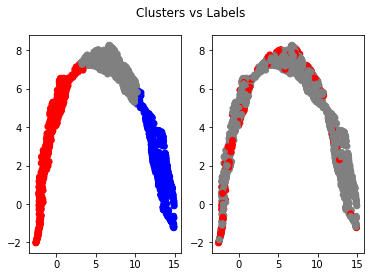

Cluster #  0 sized:  2199
[('GCS_last', 0.289), ('Age', 0.12), ('BUN_last', 0.101), ('NISysABP_lowest', 0.035), ('Weight_last', 0.034), ('GCS_first', 0.032), ('MechVentDuration', 0.027), ('Albumin_last', 0.024), ('pH_first', 0.022), ('CSRU', 0.02)]

Cluster #  1 sized:  2295
[('GCS_last', 0.178), ('BUN_last', 0.106), ('GCS_highest', 0.105), ('MechVentDuration', 0.073), ('Age', 0.072), ('CCU', 0.036), ('Length_of_stay', 0.028), ('GCS_median', 0.024), ('NISysABP_lowest', 0.023), ('Bilirubin_last', 0.023)]

Cluster #  2 sized:  2256
[('Age', 0.2), ('GCS_last', 0.188), ('GCS_first', 0.061), ('BUN_last', 0.04), ('MechVentDuration', 0.034), ('Albumin_first', 0.03), ('NISysABP_lowest', 0.027), ('RespRate_highest', 0.024), ('Glucose_last', 0.024), ('Weight_last', 0.021)]



In [9]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
q_train = qs[0]
cluster_ids = torch.argmax(q_train, axis=1)
preds_e = torch.zeros((len(z_train), 2))
feature_importances = np.zeros((args.n_clusters, args.input_dim))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_train
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_train[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]

    # Some test data might not belong to any cluster
    if len(cluster_id) > 0:
        regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
        best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
        feature_importances[j,:] = regs[j].feature_importances_
        print("Cluster # ", j, "sized: ", len(cluster_id))
        print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
        print("=========================\n")


## Baseline Model

In [10]:
f1_scores, auc_scores = [], []

for r in range(5):
    m = NNClassifier(args, input_dim=89)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset, path="./pretrained_model/checkpoint_base")

    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        m.train()
        nmi, acc, ari = 0, 0, 0

#         for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = torch.FloatTensor(X_train), torch.Tensor(y_train).type(torch.LongTensor)
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()


        m.classifier.eval()
        val_pred = m(torch.FloatTensor(X_val).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.Tensor(y_val).type(torch.LongTensor))

        val_f1 = f1_score(torch.argmax(val_pred, axis=1), y_val)
        val_auc = roc_auc_score(y_val, val_pred[:,1].data.cpu().numpy())
        es([val_f1, val_auc], m)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
            f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
            f'Val F1: {val_f1:.3f} | Val Acc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ###################################### Testing #####################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    m = es.load_checkpoint(m)
    m.classifier.eval()
    test_pred = m.classifier(torch.FloatTensor(X_test))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.Tensor(y_test).type(torch.LongTensor))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_auc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    
    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
        f'Test F1: {test_f1:.3f} | Test Acc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')


#     reg = GradientBoostingRegressor(random_state=0)

#     reg.fit(X_test, y_test)
#     best_features = np.argsort(reg.feature_importances_)[::-1][:10]
#     print("Best Features ")
#     print(column_names[best_features])
#     print("=========================\n")
print(f1_scores, auc_scores)
print("Avg. Test F1 = {:.3f}, AUC = {:.3f}".format(np.average(f1_scores), np.average(auc_scores)))

NameError: name 'NNClassifier' is not defined